## Costs 
We consider costs the state variables $h(z(t), t)$, which for example, enforce the states to be close to a given reference trajectory s.t. $h(z(t), t) = \|z(t) - \hat z(t)\|_2^2$ for a given reference trajectory $\hat z(t)$. We also consider some costs on the control variables $g(u(t), t)$ that typically regularize them to, e.g., penalize strong accelerations as $g(u(t), t) = \|u(t)\|_2^2$. Our objective is to minimize these costs along the trajectory defined by the dynamics. Namely, we want to solve the following optimization problem in continuous time:

\begin{align*}
    \min_{x, u} \quad & \int_0^T (h(z(t), t) + g(u(t), t)) dt + h(z(T), T) \\
    \textrm{s.t.} \quad & \dot z(t) = \psi(z(t), u(t)) \\
    & z(0) = \hat z_0,
\end{align*}

where $T$ is the total time of the movement and $\hat z_0$ is a given fixed initial state. After discretization, the discrete-time control problem can be written:

\begin{align*}
    \min_{\substack{z_0, \ldots, z_\tau,\\ u_0, \ldots u_{\tau-1}}} \quad & \sum_{t=0}^{\tau-1} h_t(z_t) + g_t(u_t) + h_\tau(z_\tau)\\
    \textrm{s.t.} \quad & z_{t+1} = \phi(z_t, u_t) \quad \textrm{for} \ t =1, \ldots, \tau-1 \\
    & z_0 = \hat z_0,
\end{align*}

where $\phi$ are the discrete dynamics computed through some discretization method. 

As said above, a first simple cost consists of enforcing the car to follow a given trajectory. This amounts to a tracking cost presented below.

In [6]:
import torch
import time
import math
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

<a id='tracking'></a>
### Tracking Cost
Tracks are defined as splines interpolating a given sequence of points using the package *torchcubicspline* of [[Patrick Kidger (2020)]](#refs). As a consequence, we have access to a continuous-time representation of the track rather than just a sequence of points. In this code, we will work with two tracks: a simple and a complex one. Each track is defined by its center, its inner border and its outer border. The tracks are presented in the code below. 

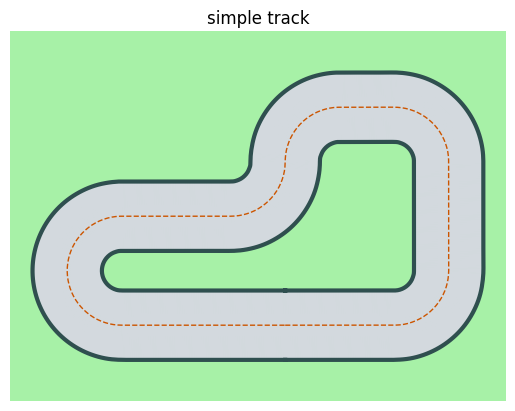

In [7]:
from envs.tracks.tracks import get_track
from envs.car import plot_track

track = 'simple' # choose among 'simple', 'complex', 'line', 'bend', 'circle'

# Get splines defining the center, the inner border and the ouoter border of the track.
center, inner, outer = get_track(track) 
plot_track(center, inner, outer)

plt.title(track + ' track')
plt.show()

Given a trajectory defined as a spline, a simple cost on the states is to take 

$$h_t(z_t) = h_t(x_t, y_t) = \|x_t - \hat x(\Delta t)\|_2^2 + \|y_t - \hat y(\Delta t)\|_2^2\quad \text{for} \ t =1, \ldots, \tau$$

where $\hat x, \hat y$ is the continuous spline and $\Delta$ is some discretization step. The disadvantage of such costs is that it enforces the car to follow the track at a constant speed which may not be realizable. We consider an alternative cost that allows the car to move along the track at a variable speed such that it can more easily take angles.

<a id='contouring'></a>

### Contouring Cost
Contouring costs have been used in various industrial applications such as machine tools for milling and turning. Here we follow the approach of [[Liniger et al 2015]](#refs) and use it for making a car race a given track.  

#### Exact contouring cost
Given a track continuously parameterized, an ideal cost is to enforce the car to be as close as possible to the track, while moving along the track as fast as possible. Formally, define the distance from the car at position $(x, y)$ to the track defined by the curve $ (\hat x(s), \hat y(s))$ as 

$$d(x, y) = \min_s\quad \sqrt{((x - \hat x(s))^2 + (y - \hat y(s))^2}.$$

Denoting 

$$s^* = s(x, y)  = \arg\min_s \quad (x - \hat x(s))^2 + (y - \hat y(s))^2,$$

the reference time on the track for a car at position $(x, y)$, the distance $d(x, y)$ can be expressed as 

$$d(x, y) = \sin(\theta(s^*))\left(x - \hat x(s^*)\right) - \cos(\theta(s^*)) \left(y - \hat y(s^*)\right),$$

where  $$\theta(s) = \frac{\partial \hat y(s)}{\partial \hat x(s)}$$ is the angle of the track with the x-axis. The distance $d(x, y)$ is illustrated in the figure below.

<center><img src="fig/exact_contouring.png" alt="exact_contouring" width="400" /></center>

An ideal cost for the problem is then defined as 
$$ h(z) = h(x, y) = d(x, y)^2 - s(x, y),$$
which enforces the car to be close to the track by minimizing $d(x, y)^2$, and also encourages the car to go as far as possible by adding the term $-s(x, y)$.

#### Contouring and lagging costs
The problem is that computing $s^*$ is computationally expansive. So we rather augment the states with a flexible reference time. Namely, we augment the state of the car by adding a variable $s$ whose objective is to approximate the reference time $s^*$. The cost is then decomposed into the *contouring cost* and the *lagging cost* defined as 

\begin{align*}
e_c(x, y, s) & = \sin(\theta(s))\left(x - \hat x(s)\right) - \cos(\theta(s)) \left(y - \hat y(s)\right) \\
e_l(x, y, s) & = -\cos(\theta(s))\left(x - \hat x(s)\right) - \sin(\theta(s)) \left(y - \hat y(s)\right).
\end{align*}

These costs are illustrated in the figure below.

<center><img src="fig/contouring_lagging.png" alt="contouring and lagging errors" width="400" /></center>

Rather than encouraging the car to make the most progress on the track, we enforce them to keep a reference speed. Namely, we consider an additional penalty of the form 

$$\|v_s - v^{\textrm{ref}}\|_2^2$$

where $v^{\textrm{ref}}$ is a parameter chosen in advance and $v_s$ is the derivative of $s$.

Finally, we let the system control the reference time through its second order derivative $a_{s}$. Overall this means that we augment the state variable by adding the variables $s$ and $v_s$ and that we augment the control variable by adding the variable $a_s$ such that the discretized problem is written for e.g. the [realistic model](dynamics.ipynb#realistic_model) of the car as
\begin{align*}
    \min_{\substack{(a_0, \delta_0, a_{s, 0}), \ldots, (a_{\tau-1}, \delta_{\tau-1},a_{s, \tau-1}}) } \quad & \sum_{t=0}^{\tau-1} q_c e_c(x_t, y_t, s_t)^2 + q_l e_l(x_t, y_t, s_t)^2  + q_v \|v_{s, t} - v^{\textrm{ref}}\|_2^2\\
    \textrm{s.t.} \quad & x_{t+1}, y_{t+1}, \theta_{t+1}, v_{x, t+1}, v_{y, t+1}, \omega_{t+1} = \phi(x_t, y_t, \theta_t, v_{x, t}, v_{y, t}, \omega_t, \delta_t, a_t) \\
   &  s_{t+1} = s_t + \Delta v_{s, t}  \\
 &   v_{s, t+1} = v_{s, t} + \Delta a_{s, t} \\
 &   z_0 = \hat z_0, 
\end{align*}
where $\phi$ is a discretization of the continuous time dynamics, $\Delta$ is a discretization step and $\hat z_0$ is a given initial state where $z_0$ regroups all state variables at time 0 (i.e., all variables except $a_0, \delta_0, a_{s, 0}$).

This cost is defined by the parameters $q_c, q_l, q_v, v^{\textrm{ref}}$ which are chosen in advance. The larger the $q_c$, the closer the car to the track. The larger the $q_l$, the closer the car to its reference time $s$. In practice, we want the reference time to be a good approximation of the ideal projection of the car on the track, so $q_l$ should be chosen large enough. On the other hand, varying $q_c$ allows having a car that is either conservative and potentially slow, or a car that is fast but inaccurate, i.e., far from the track. The most important aspect of the trajectory is to ensure that the car remains inside the track's borders defined in advance. 


#### Track barriers
To enforce the car to remain inside the track defined by some borders, we penalize the approximated distance of the car to the border when it goes outside the border as follows:
\begin{align*}
e_b^\textrm{in}(x, y, s) & =  \max(w + d^{\textrm{in}}(x, y, s), 0) & d^{\textrm{in}}(x, y, s) & =  -(z - z^\textrm{in}(s))^\top n^{\textrm{in}}(s) \\
e_b^\textrm{out}(x, y, s) & =  \max(w + d^{\textrm{out}}(x, y, s), 0) & d^{\textrm{out}}(x, y, s)  & = (z - z^\textrm{out}(s))^\top n^{\textrm{out}}(s)
\end{align*}
where $n^{\textrm{in}}(s)$ and $n^{\textrm{out}}(s)$ denote the normal at the borders at time $s$ and $w$ is the width of the car. The normals $n^{\textrm{in}}(s)$ and $n^{\textrm{out}}(s)$ can easily be computed by derivating the curves defining the inner and outer borders (we consider that the car goes along the track counter-clockwise to define these normal vectors). These costs are illustrated on the figure below.

<center><img src="fig/border_costs.png" alt="border costs" width="300" /></center>


#### Regularization
Finally we add some penalties on the control variables to smooth the movement. Namely, we add regularization on all control variables such that the cost on the control variables is simply

$$ g(u) = \|u\|_2^2. $$

#### Overall cost
The whole problem is then 
\begin{align*}
    \min_{\substack{(a_0, \delta_0, a_{s, 0}), \ldots, (a_{\tau-1}, \delta_{\tau-1},a_{s, \tau-1}}) } \quad & \sum_{t=0}^{\tau-1} q_c e_c(x_t, y_t, s_t)^2 + q_l e_l(x_t, y_t, s_t)^2  + q_v \|v_{s, t} - v^{\textrm{ref}}\|_2^2 + q_b e_b^\textrm{in}(x_t, y_t, s_t)^2 + q_b e_b^\textrm{out}(x_t, y_t, s_t)^2 + \rho \|u_t\|_2^2 \\
    \textrm{s.t.} \quad & x_{t+1}, y_{t+1}, \theta_{t+1}, v_{x, t+1}, v_{y, t+1}, \omega_{t+1} = \phi(x_t, y_t, \theta_t, v_{x, t}, v_{y, t}, \omega_t, \delta_t, a_t) \\
   &  s_{t+1} = s_t + \Delta v_{s, t}  \\
 &   v_{s, t+1} = v_{s, t} + \Delta a_{s, t} \\
 &   z_0 = \hat z_0, 
\end{align*}
with parameters $q_c, q_l, q_v, v^\textrm{ref}, q_b, \rho$. We integrate these costs in the definition of a car in the code below. 


In [8]:
from envs.tracks.tracks import get_track
from envs.torch_utils import smooth_relu
from envs.car import set_window_viewer, add_car_to_viewer, add_track_to_viewer, plot_track, plot_traj


class Car:
    def __init__(self, dt=0.02, model='real', track='simple',
                 reg_ctrl=1e-6, reg_cont=1., reg_lag=10., reg_speed=1., reg_barr=1., vref=2., vinit=1., 
                 constrain_angle=math.pi/3, acc_bounds=(-0.1, 1.)):
        super(Car, self).__init__()
        
        self.dt = dt
        self.model = model        
        self.reg_ctrl, self.reg_cont, self.reg_lag, self.reg_speed, self.reg_barr = \
            reg_ctrl, reg_cont, reg_lag, reg_speed, reg_barr
        self.vref = vref
        self.constrain_angle, self.acc_bounds = constrain_angle, acc_bounds

        # Get the track in the form of splines
        self.track, self.inner_track, self.outer_track = get_track(track)
        
        # Initialize the car with an orientation aligned with the one of the track
        dx_ref, dy_ref = self.track.derivative(torch.tensor(0.))
        theta_ref = torch.atan2(dy_ref, dx_ref)
        
        # Initial state depends on the chosen model
        if model == 'simple':
            self.init_state = torch.tensor([0., 0., theta_ref, vinit, 0., vinit])
            self.dim_ctrl, self.dim_state = 3, 6
        elif model == 'real':
            self.init_state = torch.tensor([0., 0., theta_ref, vinit, 0., 0., 0., vinit])
            self.dim_ctrl, self.dim_state = 3, 8
        else:
            raise NotImplementedError

        self.dyn_csts = pd.read_json(os.path.join('envs/bicycle_model.json'), typ='series')

        self.carlength, self.carwidth = 1.5 * self.dyn_csts['car_l'], 1.5 * self.dyn_csts['car_w']

        self.viewer = None
        
    def simple_dyn(self, state, ctrl):
        x, y, theta, v, tref, vtref = state
        a, delta, atref = ctrl
        delta = 2/math.pi*torch.arctan(delta)*self.constrain_angle
        dx = v * torch.cos(theta)
        dy = v * torch.sin(theta)
        dtheta = v * torch.tan(delta)/self.carlength
        dv = a
        dtref = vtref
        dvtref = atref
        return torch.tensor([dx, dy, dtheta, dv, dtref, dvtref])
    
    def realistic_dyn(self, state, ctrl):
        x, y, theta, vx, vy, vtheta, tref, vtref = state
        a, delta, atref = ctrl
        delta = 2/math.pi*torch.arctan(delta)*self.constrain_angle
        
        gap = self.acc_bounds[1] - self.acc_bounds[0]
        a = gap*torch.sigmoid(4 * a / gap) + self.acc_bounds[0]
        
        Cm1, Cm2, Cr0, Cr2,\
        Br, Cr, Dr, Bf, Cf, Df,\
        m, Iz, lf, lr = [self.dyn_csts[key] for key in ['Cm1', 'Cm2', 'Cr0', 'Cr2',
                                                        'Br', 'Cr', 'Dr', 'Bf', 'Cf', 'Df',
                                                        'm', 'Iz', 'lf', 'lr']]
        alphaf = delta - torch.atan2(vtheta*lf + vy, vx) 
        alphar = torch.atan2(vtheta*lr - vy, vx)
        Fry = Dr*torch.sin(Cr*torch.atan(Br*alphar))
        Ffy = Df*torch.sin(Cf*torch.atan(Bf*alphaf))
        Frx = (Cm1 - Cm2*vx)*a - Cr0 - Cr2*vx**2
        dx = torch.cos(theta)*vx - torch.sin(theta)*vy
        dy = torch.sin(theta)*vx + torch.cos(theta)*vy
        dtheta = vtheta
        dvx = (Frx - Ffy*torch.sin(delta) + m*vy*vtheta)/m
        dvy = (Fry + Ffy*torch.cos(delta) - m*vx*vtheta)/m
        dvtheta = (Ffy*lf*torch.cos(delta) - Fry*lr)/Iz
        dtref = vtref
        dvtref = atref
        return torch.stack([dx, dy, dtheta, dvx, dvy, dvtheta, dtref, dvtref])

    def discrete_dyn(self, state, ctrl):
        dyn = self.simple_dyn if self.model == 'simple' else self.realistic_dyn
        dt = self.dt
        k1 = dyn(state, ctrl)
        k2 = dyn(state + dt*k1/2, ctrl)
        k3 = dyn(state + dt*k2/2, ctrl)
        k4 = dyn(state + dt*k3, ctrl)
        return state + dt*(k1 + 2*k2 + 2*k3 + k4)/6
    
    def costs(self, next_state, ctrl):
        if self.model == 'simple':
            x, y, theta, v, tref, vtref = next_state
        else:
            x, y, theta, vx, vy, vtheta, tref, vtref = next_state
            
        # Contouring cost
        qC, qL, qVs = self.reg_cont, self.reg_lag, self.reg_speed
        x_ref, y_ref = self.track.evaluate(tref)
        dx_ref, dy_ref = self.track.derivative(tref)
        theta_ref = torch.atan2(dy_ref, dx_ref)

        cont_err = torch.sin(theta_ref)*(x-x_ref) - torch.cos(theta_ref)*(y-y_ref)
        lag_err = -torch.cos(theta_ref)*(x-x_ref) - torch.sin(theta_ref)*(y-y_ref)
        # For the cost on vtref we multiply by dt^2 for homogeneity reasons
        cost_next_state = qC*cont_err**2 + qL*lag_err**2 + qVs*(vtref-self.vref)**2*self.dt**2
        
        # Barrier cost
        point = torch.tensor([x, y])
        for i, border in enumerate([self.inner_track, self.outer_track]):
            border_point = border.evaluate(tref)
            dpos = border.derivative(tref)
            v = torch.sqrt(torch.sum(dpos**2))
            normal = torch.tensor([dpos[1], -dpos[0]])/v
            if i == 0:
                # inner
                cost_next_state = cost_next_state + self.reg_barr*smooth_relu(self.carwidth/2 - (point-border_point).dot(normal))**2
            else:
                # outer
                cost_next_state = cost_next_state + self.reg_barr*smooth_relu((point-border_point).dot(normal) + self.carwidth/2)**2
        
        # Positive reference speed 
        # We ensure that the reference speed cannot be negative to ensure that the car moves along the track 
        # and is not trying to move backward or stay in place
        cost_next_state = cost_next_state - 1e-6*torch.log(next_state[-1])
        
        # Regularization
        cost_ctrl = self.reg_ctrl*ctrl.dot(ctrl)
        return cost_next_state, cost_ctrl
        
    def step(self, ctrl):
        next_state = self.discrete_dyn(self.state, ctrl)
        self.state = next_state
        cost = sum(self.costs(next_state, ctrl))
        return next_state, cost
    
    def roll_out_cmd(self, cmd, reset=True):
        if reset:
            self.reset()
        state = self.state
        traj = [state]
        costs = []
        for ctrl in cmd:
            state, cost = self.step(ctrl)
            traj.append(state)
            costs.append(cost)
        return traj, costs

    def reset(self):
        self.state = self.init_state
        
    def set_viewer(self):
        nb_points = 500
        carlength, carwidth = 1.5 * self.dyn_csts['car_l'], 1.5 * self.dyn_csts['car_w']

        time = torch.linspace(0, max(self.track._t), nb_points)
        track_points = self.outer_track.evaluate(time).numpy()
        min_x, max_x = min(track_points[:, 0]), max(track_points[:, 0])
        min_y, max_y = min(track_points[:, 1]), max(track_points[:, 1])

        self.viewer = set_window_viewer(min_x, max_x, min_y, max_y, 2*carlength)
        add_track_to_viewer(self.viewer, self.track, self.inner_track, self.outer_track)

        self.cartrans = add_car_to_viewer(self.viewer, carlength, carwidth)

    def render(self, title=None):
        if self.viewer is None:
            self.set_viewer()
        self.cartrans.set_translation(self.state[0].item(), self.state[1].item())
        self.cartrans.set_rotation(self.state[2].item())
        return self.viewer.render(title=title)

    def plot_track(self, fig=None, ax=None):
        fig, ax = plot_track(self.track, self.inner_track, self.outer_track, fig=fig, ax=ax)
        return fig, ax

    def plot_traj(self, traj, fig, ax, add_colorbar=True):
        return plot_traj(traj, fig, ax, model=self.model, add_colorbar=add_colorbar)

You can try by yourself to optimize the cost on e.g. the circle track with the code below.

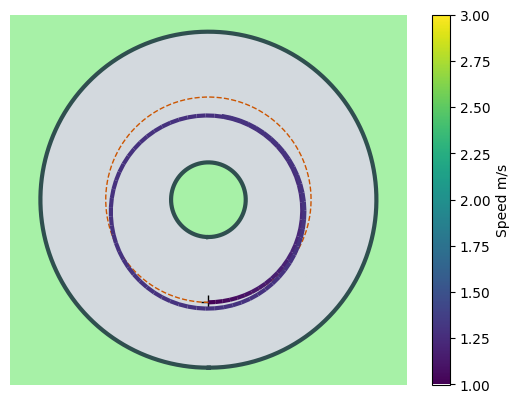

Total cost of the trajectory: 48.4844685567728


In [9]:
dt = 0.02
car = Car(dt=dt, model='real', track='circle')
horizon = 100

accs = 0.1*torch.ones(horizon) 
deltas = torch.tan(math.pi/6*torch.ones(horizon)) 
accsrefs = accs
cmd = torch.stack((accs, deltas, accsrefs), dim=1) 

# Here we plot the track and the trajectory with a color scheme corresponding to the speed of the car
traj, costs = car.roll_out_cmd(cmd)
fig, ax = car.plot_track()
fig = car.plot_traj(traj, fig, ax)
plt.show()

print('Total cost of the trajectory: {}'.format(sum(costs)))

# If you want you can still also visualize the movement of the car by uncommenting the code below. 
# car.reset()
# car.render()
# for ctrl in cmd:
#     time.sleep(dt)
#     car.step(ctrl)
#     car.render()
# car.viewer.close()

Now that our problem is entirely described, it remains to be solved, see the notebook [Open-Loop Control Algorithms](algos.ipynb).

<a id='refs'></a>
### References
**Optimization‐based autonomous racing of 1: 43 scale RC cars.**  
Alexander Liniger, Alexander Domahidi, and Manfred Morari.  
*Optimal Control Applications and Methods, 2015.*  

**torchcubicspline**  
Kidger, Patrick  
*https://github.com/patrick-kidger/torchcubicspline*  